
# **Présentation générale du jeu de données**

In [11]:
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas

arbres = pd.read_csv("p2-arbres-fr.csv", sep=";")

print(f"Le data set est composé de {arbres.shape[1]} colonnes et  {arbres.shape[0]} éléments.")



(200137, 18)


id                          0
type_emplacement            0
domanialite                 1
arrondissement              0
complement_addresse    169235
numero                 200137
lieu                        0
id_emplacement              0
libelle_francais         1497
genre                      16
espece                   1752
variete                163360
circonference_cm            0
hauteur_m                   0
stade_developpement     67205
remarquable             63098
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

In [12]:
arbres.head()

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


In [13]:
arbres.isnull().sum()

id                          0
type_emplacement            0
domanialite                 1
arrondissement              0
complement_addresse    169235
numero                 200137
lieu                        0
id_emplacement              0
libelle_francais         1497
genre                      16
espece                   1752
variete                163360
circonference_cm            0
hauteur_m                   0
stade_developpement     67205
remarquable             63098
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

# **Démarche méthodologique d’analyse de données**

In [2]:
# replace nan's in specie column
null_species_trees = arbres[arbres["libelle_francais"].isnull()]
for index, row in null_species_trees.iterrows():
    arbres.at[index, "libelle_francais"] = "Inconnu"

In [3]:
# get rid of aberrant values and replace nan's in height and circumference columns
caracs = ["circonference_cm", "hauteur_m"]
especes = arbres.libelle_francais.unique() # list of unique tree species

corrections = pd.DataFrame(columns=["Espece", "Nombre d'arbres", "Valeurs aberrantes/manquantes"])

for nesp, esp in enumerate(especes):
    
    counter = 0
     
    # getting sub dafaframe for a specific specie
    espece_mask = arbres["libelle_francais"] == esp
    espece_arbres = arbres[espece_mask]
    # getting desciptive statistics
    stats = espece_arbres[caracs].describe()

    for carac in caracs:
        # calculating thresholds for aberrant values
        q1 = stats[carac].loc["25%"]
        q2 = stats[carac].loc["50%"]
        q3 = stats[carac].loc["75%"]
        lower_bound = 0 # a newborn tree can be any height or circumference
        upper_bound = q3 + 3 * (q3 - q1)
        default_value = q3 + 1.5 * (q3 - q1)
        
        # replacing aberrant & missing values in parent dataframe
        for index, row in espece_arbres.iterrows():
            if math.isnan(row[carac]) or row[carac] == 0: # missing value, replacing with median
                counter += 1
                arbres.at[index, carac] = q2
            if row[carac] > upper_bound: # too tall
                counter += 1
                arbres.at[index, carac] = default_value
            elif row[carac] < lower_bound: # too small, replacing with median
                counter += 1
                arbres.at[index, carac] = q2
                
    corrections.loc[nesp] = [esp, espece_arbres.shape[0], counter]

corrections



,Espece,Nombre d'arbres,Valeurs aberrantes/manquantes
0,Marronnier,25207,4121
1,If,1995,797
2,Erable,18389,10088
3,Arbre à miel,53,40
4,Platane,42508,5839
...,...,...,...
188,Ormeau épineux,1,2
189,Ostryer,1,2
190,Xanthoceras,1,2
191,Parrotiopsis,2,4


In [4]:
# replace nan's in grow stages column
stages = [x for x in arbres.stade_developpement.unique() if str(x) != 'nan']
default_avgs = [0, 0, 0, 0]
default_avgs[stages.index("J")] = 1
for arrdt in arbres.arrondissement.unique():
    # get all trees for each arrdt
    arrdt_arbres = arbres[arbres["arrondissement"] == arrdt]
    # get trees without specified development stage
    null_stage_trees = arrdt_arbres[arrdt_arbres["stade_developpement"].isnull()]
    print(f"In {arrdt}, {null_stage_trees.shape[0]} development stages were missing.")
    # get species concerned
    for spe in null_stage_trees.libelle_francais.unique():
        avgs = []
        # get trees with same specie in specific arrdt
        current_trees = arrdt_arbres[arrdt_arbres["libelle_francais"] == spe]
        current_null_trees = null_stage_trees[null_stage_trees["libelle_francais"] == spe]
        # get average height for trees with same location and specie, for each stage
        for stage in stages:
            avgs.append(current_trees[current_trees["stade_developpement"] == stage]["hauteur_m"].mean())
        # in case no other similar tree is documented, we assign the "Junior" stage
        if all([math.isnan(x) for x in avgs]): avgs = [x for x in default_avgs]
        # replace missing development stages with closest distance to previously calculated averages
        for index, row in current_null_trees.iterrows():
            h = row["hauteur_m"]
            new_stage = stages[avgs.index(min(avgs, key=lambda x:abs(x-h)))]
            arbres.at[index, "stade_developpement"] = new_stage

arbres.isnull().sum()


In PARIS 7E ARRDT, 731 development stages are missing.
In PARIS 17E ARRDT, 3302 development stages are missing.
In PARIS 16E ARRDT, 4867 development stages are missing.
In PARIS 4E ARRDT, 724 development stages are missing.
In PARIS 13E ARRDT, 6451 development stages are missing.
In PARIS 12E ARRDT, 3821 development stages are missing.
In PARIS 19E ARRDT, 6300 development stages are missing.
In PARIS 14E ARRDT, 1244 development stages are missing.
In PARIS 15E ARRDT, 7427 development stages are missing.
In PARIS 3E ARRDT, 259 development stages are missing.
In PARIS 20E ARRDT, 2902 development stages are missing.
In PARIS 18E ARRDT, 2969 development stages are missing.
In PARIS 6E ARRDT, 339 development stages are missing.
In PARIS 11E ARRDT, 1181 development stages are missing.
In PARIS 1ER ARRDT, 411 development stages are missing.
In PARIS 2E ARRDT, 79 development stages are missing.
In PARIS 5E ARRDT, 636 development stages are missing.
In VAL-DE-MARNE, 4126 development stages are 

id                          0
type_emplacement            0
domanialite                 1
arrondissement              0
complement_addresse    169235
numero                 200137
lieu                        0
id_emplacement              0
libelle_francais            0
genre                      16
espece                   1752
variete                163360
circonference_cm            0
hauteur_m                   0
stade_developpement         0
remarquable             63098
geo_point_2d_a              0
geo_point_2d_b              0
dtype: int64

# **Synthèse de l'analyse de données**

In [5]:
# https://geopandas.org/gallery/create_geopandas_from_pandas.html#sphx-glr-gallery-create-geopandas-from-pandas-py
# https://geopandas.org/geocoding.html
mymap = geopandas.read_file(os.path.join(os.getcwd(), "map", "Territoires_MGP.shp"))

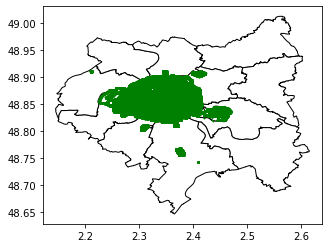

In [6]:
fig, ax = plt.subplots()
mymap.crs = {'init':'epsg:4326'}
mymap.plot(ax=ax, color="white", edgecolor="black");
test_df = arbres
gdf = geopandas.GeoDataFrame(test_df, geometry=geopandas.points_from_xy(test_df.geo_point_2d_b, test_df.geo_point_2d_a))
gdf.plot(ax=ax, color='green', markersize=1)
plt.show()

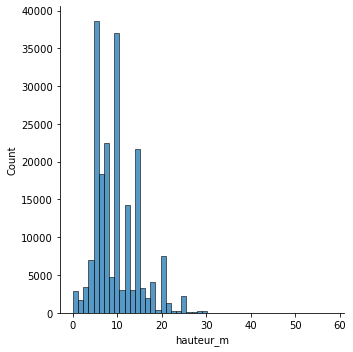

In [7]:
sns.displot(arbres, x="hauteur_m", bins=50)

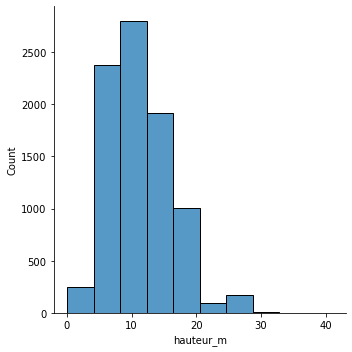

In [8]:
arrdts = arbres.arrondissement.unique()
arrdt_mask = arbres["arrondissement"] == arrdts[0] # 7e arrdt trees
arrdt_arbres = arbres[arrdt_mask]
arrdt_arbres.head()
sns.displot(arrdt_arbres, x="hauteur_m", bins=10)

In [10]:
dom = [x for x in arbres.domanialite.unique() if str(x) != 'nan']
print(dom)

['Jardin', 'Alignement', 'DJS', 'DFPE', 'CIMETIERE', 'DASCO', 'DAC', 'PERIPHERIQUE', 'DASES']
